<a href="https://colab.research.google.com/github/rodrigosimass/mnist_FFNN_CNN/blob/master/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up



In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import KFold
import numpy as np
import sklearn.decomposition
import matplotlib.pyplot as plt

In [0]:
mnist_data, mnist_info = tfds.load('mnist', with_info=True)
mnist_train_x = np.asarray([instance['image']/255 for instance in tfds.as_numpy(mnist_data['train'])])
mnist_train_y = np.asarray([instance['label'] for instance in tfds.as_numpy(mnist_data['train'])])
mnist_test_x = np.asarray([instance['image']/255 for instance in tfds.as_numpy(mnist_data['test'])])
mnist_test_y = np.asarray([instance['label'] for instance in tfds.as_numpy(mnist_data['test'])])

In [0]:
def isBest(result, results):
  if(len(results)==0):
    return True
  if(result>max(results)):
    return True
  return False

In [0]:
def KFoldcrossValidation(K,model,train_x,train_y, _epochs, _batch_size, _verbose):
    kf = KFold(n_splits=K)
    results = []
    i = 1

    print("CROSS VALIDATION STARTED")
    for train_idx, val_idx in kf.split(train_x, train_y):
        #SPLIT THE DATA
        print("Fold ",i,"/",K)
        i = i+1
        train_x = mnist_train_x[train_idx]
        train_y = mnist_train_y[train_idx]
        val_x = mnist_train_x[val_idx]
        val_y = mnist_train_y[val_idx]
        val_set = (val_x, val_y)

        earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
        checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_baseline_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

        model_hist = model.fit(train_x, train_y, validation_data= val_set, callbacks=[earlystop,checkpoint], epochs=_epochs, batch_size=_batch_size, verbose=_verbose)

        model.load_weights('mnist_baseline_best.h5')
        if(isBest(checkpoint.best,results)):
            model.save('best_model.h5')
            best_train = model_hist
        results.append(checkpoint.best)
    
    return results, best_train

# Baseline
No hidden 

In [13]:
mnist_baseline_model = tf.keras.Sequential(name='mnist_baseline')
mnist_baseline_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
mnist_baseline_model.add(tf.keras.layers.Flatten(name='flatten'))
mnist_baseline_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
mnist_baseline_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
mnist_baseline_model.summary()

Model: "mnist_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
output (Dense)               (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [14]:
results, train = KFoldcrossValidation(5,mnist_baseline_model,mnist_train_x,mnist_train_y, 1, 256, 0)

print(results)

CROSS VALIDATION STARTED
Fold  1 / 5

Epoch 00001: val_accuracy improved from -inf to 0.76092, saving model to mnist_baseline_best.h5
Fold  2 / 5

Epoch 00001: val_accuracy improved from -inf to 0.82067, saving model to mnist_baseline_best.h5
Fold  3 / 5

Epoch 00001: val_accuracy improved from -inf to 0.83558, saving model to mnist_baseline_best.h5
Fold  4 / 5

Epoch 00001: val_accuracy improved from -inf to 0.84800, saving model to mnist_baseline_best.h5
Fold  5 / 5

Epoch 00001: val_accuracy improved from -inf to 0.85567, saving model to mnist_baseline_best.h5
[0.7609166502952576, 0.8206666707992554, 0.8355833292007446, 0.8479999899864197, 0.8556666374206543]


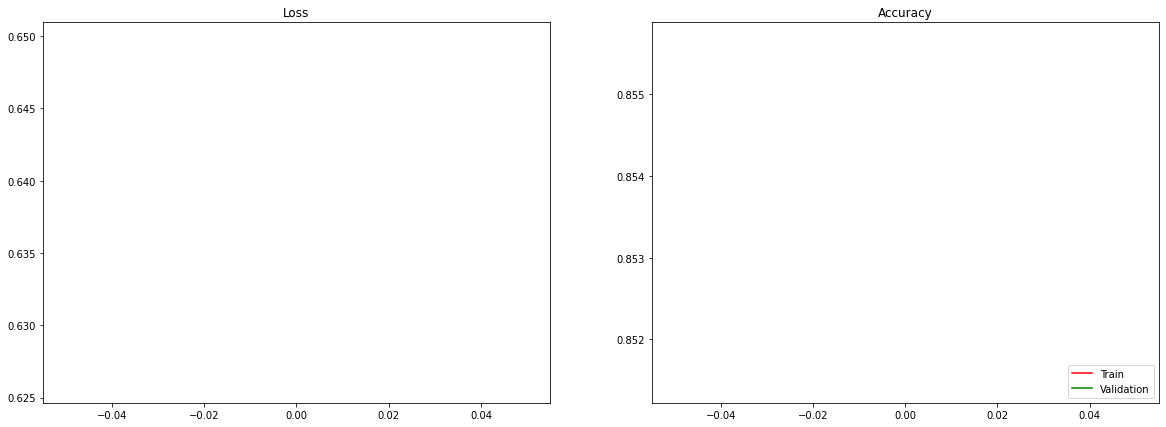

In [15]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(train.history['loss'], '-r', label='Train')
loss_ax.plot(train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(train.history['accuracy'], '-r', label='Train')
acc_ax.plot(train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show()

test the baseline

In [9]:
mnist_baseline_model.load_weights('mnist_baseline_best.h5')
loss, acc = mnist_baseline_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy: {}'.format(acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.2835 - accuracy: 0.9210
Accuracy: 0.9210000038146973


#Feed-Forward Neural Networks

test several models with different number of layers and neurons

cross validation is used and the best fold is selected in order to assess performance

---



In [0]:
num_hidden_layers = [1,2]
num_hidden_neurons = [50,100]
num_folds = 5; #cross validation
eps = 10000 #epochs

for layers in num_hidden_layers:
    print("\n\nhidden_layers=",layers)
    for num_neur in num_hidden_neurons:
        kf = KFold(n_splits=num_folds)
        results = []
        i = 1
        print("    num_neurons:",num_neur)
        for train_idx, val_idx in kf.split(mnist_train_x, mnist_train_y):
            #SPLIT THE DATA
            train_x = mnist_train_x[train_idx]
            train_y = mnist_train_y[train_idx]
            val_x = mnist_train_x[val_idx]
            val_y = mnist_train_y[val_idx]
            val_set = (val_x, val_y)

            #BUILD THE NN
            mlp = tf.keras.Sequential(name='MLP-1HU')
            mlp.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
            mlp.add(tf.keras.layers.Flatten(name='flatten'))
            for i in range (layers):
                nm = "HU" + str(i)
                mlp.add(tf.keras.layers.Dense(num_neur, activation='tanh', name=nm))
            mlp.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))

            mlp.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

            #DEFINE CALL BACKS
            earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=0)
            checkpoint_train = tf.keras.callbacks.ModelCheckpoint('MLP-1HU.h5', monitor='accuracy', verbose=0, save_best_only=True)
            checkpoint_valid = tf.keras.callbacks.ModelCheckpoint('multi_layer_2.h5', monitor='val_accuracy', verbose=0, save_best_only=True)

            #TRAIN
            mlp_train = mlp.fit(mnist_train_x, mnist_train_y, validation_data= val_set, callbacks=[earlystop,checkpoint_train,checkpoint_valid], epochs=eps, batch_size=256, verbose=0)

            #ASSESS PERFORMANCE
            mlp.load_weights('multi_layer_2.h5')
            if(isBest(checkpoint_valid.best,results)):
                best_val = checkpoint_valid.best
                best_train = checkpoint_train.best
            results.append(checkpoint_valid.best);
            
        print(results)
        print("        val:",best_val," trn:",best_train)

train one model

In [0]:
num_hidden_layers = 2
num_neur = 100
num_folds = 5; #cross validation
eps = 10000 #epochs

kf = KFold(n_splits=num_folds)
results = []
i = 1
for train_idx, val_idx in kf.split(mnist_train_x, mnist_train_y):
    print("fold",i,"/",num_folds)
    i+=1
    #SPLIT THE DATA
    train_x = mnist_train_x[train_idx]
    train_y = mnist_train_y[train_idx]
    val_x = mnist_train_x[val_idx]
    val_y = mnist_train_y[val_idx]
    val_set = (val_x, val_y)


    #BUILD THE NN
    mlp = tf.keras.Sequential(name='MLP-1HU')
    mlp.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
    mlp.add(tf.keras.layers.Flatten(name='flatten'))
    for j in range (num_hidden_layers):
        nm = "HU" + str(j)
        mlp.add(tf.keras.layers.Dense(num_neur, activation='tanh', name=nm))
    mlp.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))

    mlp.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    #DEFINE CALL BACKS
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=0)
    checkpoint_train = tf.keras.callbacks.ModelCheckpoint('MLP-1HU.h5', monitor='accuracy', verbose=0, save_best_only=True)
    checkpoint_valid = tf.keras.callbacks.ModelCheckpoint('multi_layer_2.h5', monitor='val_accuracy', verbose=0, save_best_only=True)
    #TRAIN
    mlp_train = mlp.fit(mnist_train_x, mnist_train_y, validation_data= val_set, callbacks=[earlystop,checkpoint_train,checkpoint_valid], epochs=eps, batch_size=256, verbose=0)

    #ASSESS PERFORMANCE
    mlp.load_weights('multi_layer_2.h5')
    if(isBest(checkpoint_valid.best,results)): #TODO verificar se esta a usar a melhor validation
        #SAVE MODEL OF BEST FOLD
        mlp.save_weights('best_MLP.h5')
        best_model = mlp_train
        best_val = checkpoint_valid.best
        best_train = checkpoint_train.best
    results.append(checkpoint_valid.best);

plot the train:

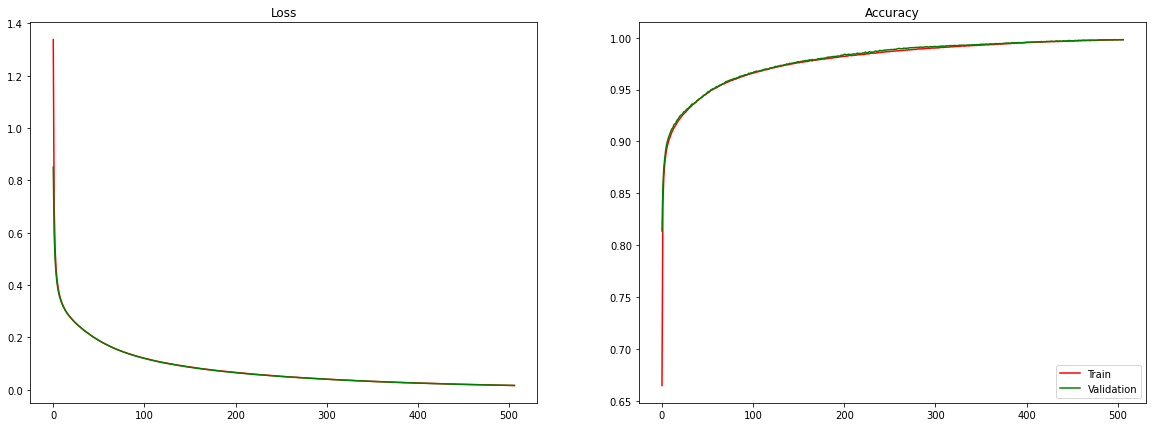

In [0]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(best_model.history['loss'], '-r', label='Train')
loss_ax.plot(best_model.history['val_loss'], '-g', label='Validation')
acc_ax.set_title('Accuracy')
acc_ax.plot(best_model.history['accuracy'], '-r', label='Train')
acc_ax.plot(best_model.history['val_accuracy'], '-g', label='Validation')
plt.legend(loc=4)
plt.show()

and finally... use the test set

In [0]:
#stats of all the folds
print("All folds:")
print(results)
#satts of best fold
print("Best fold:")
print("valid acc:",best_val)
print("train acc:",best_train)
#and finally we test
mlp.load_weights('best_MLP.h5')
loss, acc = mlp.evaluate(mnist_test_x, mnist_test_y)
print('\n---------------------------------------\n| TEST ACCURACY =  {}  |\n---------------------------------------\n'.format(acc))

All folds:
[0.9929999709129333, 0.9897500276565552, 0.996999979019165, 0.9950000047683716, 0.9981666803359985]
Best fold:
valid acc: 0.9981666803359985
train acc: 0.9980666637420654
313/313 [==============================] - 1s 2ms/step - loss: 0.0727 - accuracy: 0.9778

---------------------------------------
| TEST ACCURACY =  0.9778000116348267  |
---------------------------------------



# CNN

In [18]:
CNN = tf.keras.Sequential(name='mnist_cnn')
CNN.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
CNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='convolution1'))
CNN.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='convolution2'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling'))
CNN.add(tf.keras.layers.Dropout(0.5, name='dropout'))
CNN.add(tf.keras.layers.Flatten(name='flatten'))
CNN.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))

CNN.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

conv_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=0)
conv_checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_conv_best.h5', monitor='val_accuracy', verbose=0, save_best_only=True)

mnist_CNN_train = CNN.fit(mnist_train_x, mnist_train_y, validation_split=0.2,callbacks=[conv_earlystop,conv_checkpoint], epochs=10000, batch_size=256)


Epoch 1/10000
188/188 [==============================] - 3s 16ms/step - loss: 1.5382 - accuracy: 0.5306 - val_loss: 0.5239 - val_accuracy: 0.8576
Epoch 2/10000
188/188 [==============================] - 3s 14ms/step - loss: 0.5444 - accuracy: 0.8301 - val_loss: 0.4014 - val_accuracy: 0.8848
Epoch 3/10000
188/188 [==============================] - 3s 15ms/step - loss: 0.4649 - accuracy: 0.8577 - val_loss: 0.3660 - val_accuracy: 0.8933
Epoch 4/10000
188/188 [==============================] - 3s 14ms/step - loss: 0.4288 - accuracy: 0.8694 - val_loss: 0.3451 - val_accuracy: 0.8992
Epoch 5/10000
188/188 [==============================] - 3s 14ms/step - loss: 0.4098 - accuracy: 0.8765 - val_loss: 0.3416 - val_accuracy: 0.9030
Epoch 6/10000
188/188 [==============================] - 3s 14ms/step - loss: 0.3948 - accuracy: 0.8817 - val_loss: 0.3297 - val_accuracy: 0.9038
Epoch 7/10000
188/188 [==============================] - 3s 15ms/step - loss: 0.3798 - accuracy: 0.8862 - val_loss: 0.3218 -

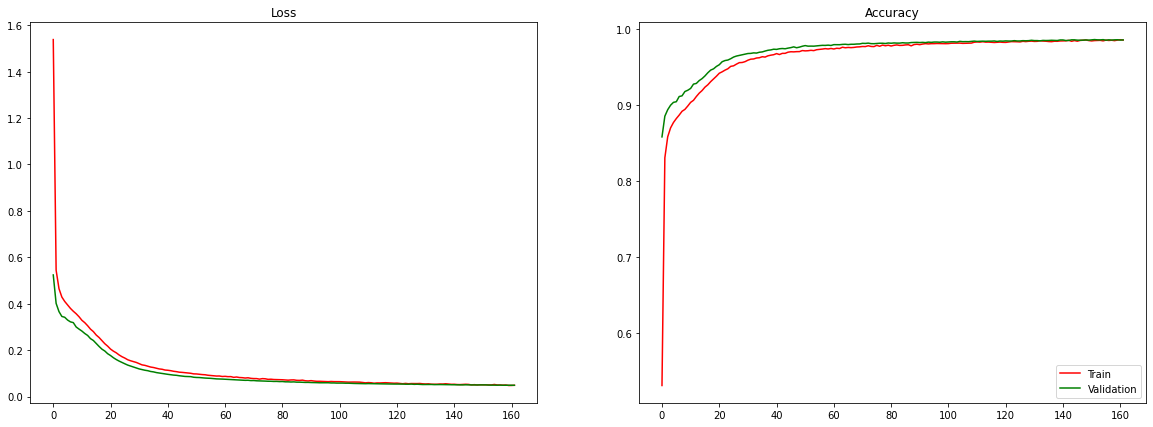

In [19]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(mnist_CNN_train.history['loss'], '-r', label='Train')
loss_ax.plot(mnist_CNN_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(mnist_CNN_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(mnist_CNN_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show() 

In [20]:
CNN.load_weights('mnist_conv_best.h5')
loss, acc = CNN.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy: {}'.format(acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.0415 - accuracy: 0.9863
Accuracy: 0.986299991607666
